In [14]:
from collections import Counter
import pandas as pd
import numpy as np
import tqdm
import pickle
import matplotlib.pyplot as plt
from Bio.PDB import *
from rdkit import Chem
import os
import time
import shutil
from Bio.SeqUtils import seq1
import gzip
import tarfile
import sys
import random
from rdkit.Chem import rdFreeSASA
from rdkit import Chem
from rdkit.Chem.Descriptors import MolWt
import pybel
from rdkit.Chem.EnumerateStereoisomers import EnumerateStereoisomers

In [9]:
### 0. Prepare structure 373 for docking
### Important: structure has already been prepared in pocketvec_Murd.ipynb

### GET SMILES FROM LIGANDS
path = "/aloy/home/acomajuncosa/MurD/GitHub/osa-murd/data/structures"
os.chdir(path)
frags = ['349', "373", "374", "378"]

for frag in frags:
    if frag == '349':
        command = 'obabel ' + frag + "_ligand_only.pdb" + " -osmi > frags.smi"
    else:
        command = 'obabel ' + frag + "_ligand_only.pdb" + " -osmi >> frags.smi"
    os.system(command)

In [54]:
# Are all molecules flat?  YES THEY ARE

# molecules = pybel.readfile('sdf', '/aloy/home/acomajuncosa/MurD/GitHub/osa-murd/data/docking/full_lib/CDI_BMS_DivSet_300k_CleanSlate.sdf')
# coordinates = []

# for mol in tqdm.tqdm(molecules):
#     atoms = np.array([i.coords for i in mol.atoms])[:,2]  # Take all the z coords
#     coordinates.extend(atoms)
    
# print(Counter(coordinates))

In [55]:
### 1. SDF to smiles using obabel (it takes ~3min)
path_to_dataset = "../data/docking/full_lib/CDI_BMS_DivSet_300k_CleanSlate.sdf.gz"
path_to_output = "../data/docking/full_lib/smiles.smi"

command = "obabel " + path_to_dataset + " -osmi > " + path_to_output
os.system(command)

0

In [2]:
# ### 1. Take smiles directly from SDF (it takes ~2min)
# sdf = pybel.readfile('sdf', '../data/docking/full_lib/CDI_BMS_DivSet_300k_CleanSlate.sdf.gz')
# smiles = [[i.data['BMS (canonical SMILES)'], i.data['IDNUMBER']] for i in tqdm.tqdm(sdf)]

# with open("../data/docking/full_lib/smiles.smi", "w") as f:
#     for s in smiles:
#         f.write("\t".join(s) + "\n")

In [15]:
smiles = pd.read_csv("../data/docking/full_lib/smiles.smi", sep='\t', names=['smiles', 'id'])
smiles

smiles         id
0       CC1(C)Cc2c(C#N)c(nc(c2CO1)N1CCOCC1)SCC(=O)Nc1c...  D396-0181
1                                          CC(CBr)n1ncnn1  8009-0167
2                     CCCCS(=O)(=O)N=C1NCN(CC(=O)[O-])CN1  5044-0010
3       C[C@@]12CC[C@H](O)C[C@H]1[C@@H](O)CC1[C@H]2C[C...  N037-0036
4                             Cc1[nH]c(=S)[nH]c(=O)c1CCCO  3399-0213
...                                                   ...        ...
300534  CCCCNC(=O)C1(CCC1)c1ccc(cc1)NS(=O)(=O)c1cc(OC)...  L426-0625
300535  CCCCN(CC)c1ccc(cc1C(=O)O)NS(=O)(=O)c1cc(F)c(F)cc1  F294-0550
300536  CN(C)CCN(CC)c1ccc(cc1NS(=O)(=O)c1ccc(C)cc1C)C(...  F295-0500
300537                Nc1c(Br)cc(cc1Br)NS(=O)(=O)c1ccccc1  R052-1647
300538                   Cc1ccc(cc1)NS(=O)(=O)c1ccc(N)cc1  R004-0058

[300539 rows x 2 columns]

In [16]:
mols = [Chem.MolFromSmiles(i) for i in tqdm.tqdm(smiles['smiles'], position=0)]
smiles['nonisomeric'] = [Chem.MolToSmiles(i, isomericSmiles=False) for i in tqdm.tqdm(mols)]
del mols

100%|██████████| 300539/300539 [00:30<00:00, 10000.87it/s]


In [ ]:
# 2. Calculate stereoisomers & inchies
mols = [Chem.MolFromSmiles(i) for i in tqdm.tqdm(smiles['nonisomeric'], position=0)]
inchi = [Chem.MolToInchi(i) for i in mols]

smiles['inchi'] = inchi

100%|██████████| 300539/300539 [00:53<00:00, 5623.52it/s]
RDKit WARNING: [14:15:53] WARNING: Omitted undefined stereo
RDKit WARNING: [14:15:53] WARNING: Proton(s) added/removed
RDKit WARNING: [14:15:53] WARNING: Omitted undefined stereo
RDKit WARNING: [14:15:53] WARNING: Omitted undefined stereo
RDKit WARNING: [14:15:53] WARNING: Omitted undefined stereo
RDKit WARNING: [14:15:53] WARNING: Omitted undefined stereo
RDKit WARNING: [14:15:53] WARNING: Omitted undefined stereo
RDKit WARNING: [14:15:53] WARNING: Omitted undefined stereo
RDKit WARNING: [14:15:53] WARNING: Omitted undefined stereo
RDKit WARNING: [14:15:53] WARNING: Charges were rearranged
RDKit WARNING: [14:15:53] WARNING: Omitted undefined stereo
RDKit WARNING: [14:15:53] WARNING: Omitted undefined stereo
RDKit WARNING: [14:15:53] WARNING: Charges were rearranged; Omitted undefined stereo
RDKit WARNING: [14:15:53] WARNING: Charges were rearranged; Omitted undefined stereo
RDKit WARNING: [14:15:53] WARNING: Proton(s) added/rem

In [ ]:
del mols

In [ ]:
with open("/aloy/home/acomajuncosa/MurD/GitHub/osa-murd/data/docking/full_lib/nonisomeric_smiles.smi", "w")

In [64]:
a = [i for i in EnumerateStereoisomers(Chem.MolFromSmiles(smiles['nonisomeric'].tolist()[15]))]

['COC(=O)N[C@H](C(=O)N1CCC[C@@H]1c1ncc(C#CC#CC#CC#Cc2cnc([C@@H]3CCCN3C(=O)[C@H](NC(=O)OC)C(C)C)[nH]2)[nH]1)C(C)C',
 'COC(=O)N[C@@H](C(=O)N1CCC[C@@H]1c1ncc(C#CC#CC#CC#Cc2cnc([C@@H]3CCCN3C(=O)[C@H](NC(=O)OC)C(C)C)[nH]2)[nH]1)C(C)C',
 'COC(=O)N[C@H](C(=O)N1CCC[C@H]1c1ncc(C#CC#CC#CC#Cc2cnc([C@@H]3CCCN3C(=O)[C@H](NC(=O)OC)C(C)C)[nH]2)[nH]1)C(C)C',
 'COC(=O)N[C@@H](C(=O)N1CCC[C@H]1c1ncc(C#CC#CC#CC#Cc2cnc([C@@H]3CCCN3C(=O)[C@H](NC(=O)OC)C(C)C)[nH]2)[nH]1)C(C)C',
 'COC(=O)N[C@H](C(=O)N1CCC[C@@H]1c1ncc(C#CC#CC#CC#Cc2cnc([C@H]3CCCN3C(=O)[C@H](NC(=O)OC)C(C)C)[nH]2)[nH]1)C(C)C',
 'COC(=O)N[C@@H](C(=O)N1CCC[C@@H]1c1ncc(C#CC#CC#CC#Cc2cnc([C@H]3CCCN3C(=O)[C@H](NC(=O)OC)C(C)C)[nH]2)[nH]1)C(C)C',
 'COC(=O)N[C@H](C(=O)N1CCC[C@H]1c1ncc(C#CC#CC#CC#Cc2cnc([C@H]3CCCN3C(=O)[C@H](NC(=O)OC)C(C)C)[nH]2)[nH]1)C(C)C',
 'COC(=O)N[C@H](C(=O)N1CCC[C@@H]1c1ncc(C#CC#CC#CC#Cc2cnc([C@@H]3CCCN3C(=O)[C@@H](NC(=O)OC)C(C)C)[nH]2)[nH]1)C(C)C',
 'COC(=O)N[C@H](C(=O)N1CCC[C@H]1c1ncc(C#CC#CC#CC#Cc2cnc([C@@H]3CCCN3C(=O)[C@@H](NC

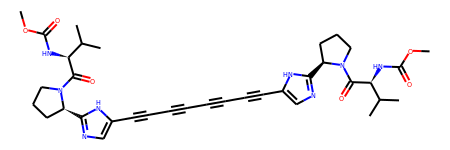

In [82]:
Chem.MolFromSmiles([Chem.MolToSmiles(i) for i in a][1])

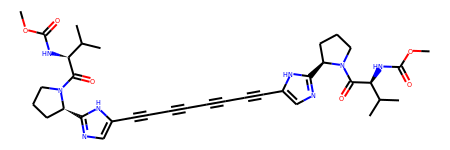

In [65]:
a[0]

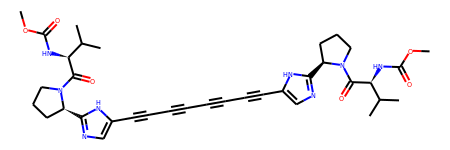

In [66]:
a[1]

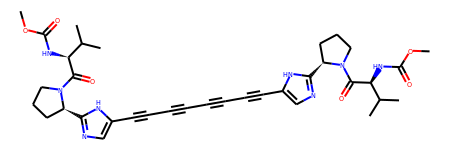

In [67]:
a[2]

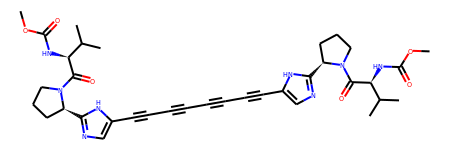

In [68]:
a[3]

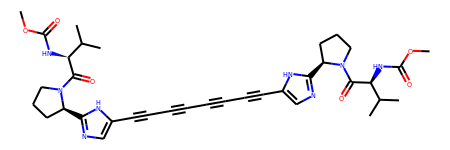

In [69]:
a[4]

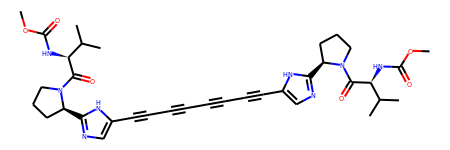

In [70]:
a[5]

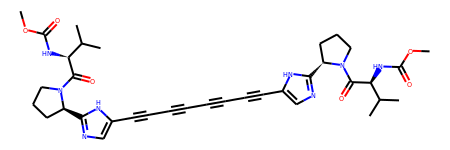

In [71]:
a[6]

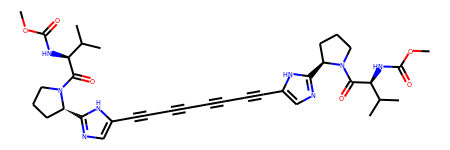

In [72]:
a[7]

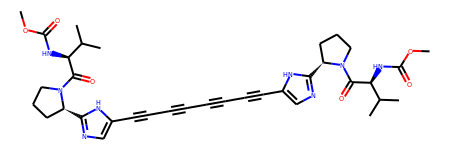

In [73]:
a[8]

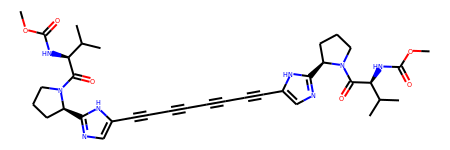

In [74]:
a[9]

In [32]:
r_smiles = smiles.sample(n=100, random_state=42)
print("\n".join(list([i + "\t" + j for i, j in zip(list(r_smiles['smiles']), list(r_smiles['id']))])))

O=C(c1cc2nc[nH]c2cc1)N1CCC2(CC(Cc3cccc(F)c3)CCO2)CC1	T500-0745
Cc1c(c(nn1C)C(=O)N(C)C12CC3CC(C1)CC(C2)C3)[N+](=O)[O-]	Y500-2158
Cn1c(=S)n(CN2CCCCC2)nc1c1ccco1	8011-0872
O=C(CSCc1cc(=O)n2nc(sc2n1)C1CC1)Nc1ccccc1Cl	G432-0160
CCOC(=O)c1cc(ccc1OS(=O)(=O)c1ccc(Cl)cc1)[N+](=O)[O-]	8010-0467
O=C1c2ccccc2C(Nc2cc3OCCOc3cc2)N1c1ccccn1	C430-0257
Cc1nc(nc2c1CC(=O)N2CCOC)c1ccncc1	T816-0321
COc1cc(OC)c(cc1)c1ccc(nn1)N1CCN(CC1)C(=O)CN(C1CC1)C(=O)c1cccs1	V007-4561
Cn1c2ccc(cc2oc1=O)S(=O)(=O)CCC(=O)N1CCN(CC1)c1cc(ccc1)OC	E975-1104
CCOc1cc(ccc1OCC)c1csc2c(=O)[nH]c(nc12)N1CCC(Cc2ccccc2)CC1	Z250-0270
CCOC(=O)c1cccc(c1)NC(=O)NCc1noc2ccccc12	E567-0173
Nc1nc(Cn2c(nc3ccccc23)c2nonc2N)nc(n1)N1CCOCC1	8010-7266
Cc1ccc(cc1)C(=O)N(C1CCN(Cc2ccncc2)CC1)c1ccc(cc1)OC	V020-6947
Cc1nc(nc2CC(CC(=O)c12)c1ccc(cc1OC)OC)N1CCc2ccccc12	D367-0356
O=C(Cc1csc(n1)n1cccc1)NCCc1nnc2ccccn12	Y041-7033
Cc1c(Cl)c(C)nn1CCc1nnc(o1)c1ccc(COc2cc3OCOc3cc2)o1	Y501-7190
OC[C@@H]1CN(C[C@H]1NC(=O)c1cc2ccccc2[nH]1)c1ccncn1	S823-1108
COc1cc(cc(OC)

In [20]:
N = 20
print("\n".join(list([i + "\t" + j for i, j in zip(list(smiles['smiles'])[:N], list(smiles['id'])[:N])])))

CC1(C)Cc2c(C#N)c(nc(c2CO1)N1CCOCC1)SCC(=O)Nc1cc2ccccc2cc1	D396-0181
CC(CBr)n1ncnn1	8009-0167
CCCCS(=O)(=O)N=C1NCN(CC(=O)[O-])CN1	5044-0010
C[C@@]12CC[C@H](O)C[C@H]1[C@@H](O)CC1[C@H]2C[C@@H]2[C@H]3CN4C[C@@H](C)CC[C@@H]4[C@@H](C)[C@@H]3CC[C@]12O	N037-0036
Cc1[nH]c(=S)[nH]c(=O)c1CCCO	3399-0213
CN1[C@@H]2NC(=O)N[C@@H]2N(CCC)C1=O	6007-0025
CCOC(=O)c1c(N)nc2CCCn12	8018-5248
CCN1CCN(CC1)c1nccn2C(C)CN=c12	T849-0011
CN(C)Cc1nnnn1c1ccc(cc1)n1nnnc1CN(C)C	8008-7346
CC1(CC(=O)OCC)C=C(CC(=O)OCC)C(=C(N)C1(C#N)C#N)C#N	3483-0063
OC(=O)CCCC1OC(CCCC(=O)O)OC(CCCC(=O)O)O1	8019-4676
CCn1nnc2c1ncnc2NCCN1CCOCC1	G857-2311
O=C1CC(C2COC1O2)n1nnn(CCn2nnn(C3CC(=O)C4OC3CO4)c2=S)c1=S	8014-9077
Cn1cc(cn1)NC(=O)c1cc(n[nH]1)c1c(C)nn(CC)c1C	Y043-3433
COc1ccc(cc1)c1nc2ccc(cc2nc1c1ccc(cc1)OC)c1cc2nc(c(nc2cc1)c1ccc(cc1)OC)c1ccc(cc1)OC	2624-0195
CC(C)[C@@H](NC(=O)OC)C(=O)N1CCC[C@@H]1c1[nH]c(cn1)C#CC#CC#CC#Cc1cnc([nH]1)[C@H]1CCCN1C(=O)[C@H](NC(=O)OC)C(C)C	H027-4102C
Cc1cc(C)nc2sc3CN(C(=O)OC)N(Cc3[n+]12)C(=O)OC	8007-1521
[O-]

In [22]:
np.sum(smiles['stereoisomers'])

476785

In [135]:
out = pybel.readfile('sdf', '/aloy/home/acomajuncosa/MurD/GitHub/docking/kraken/ligand_preparation/1/out.sdf')
lib = []

for i in out:
    print(str(i).strip())# + "\t".join([i.data['_MOLCOUNT'], i.data['DISTR[pH=7]'], i.data[ 'TAUTOMER_DISTRIBUTION']]))
    lib.append(str(i).strip().split("\t"))

CC1(C)Cc2c(C#N)c(nc(c2CO1)N1CCOCC1)SCC(=O)Nc1cc2ccccc2cc1	D396-0181
CC1(C)Cc2c(C#N)c(nc(c2CO1)N1CCOCC1)SCC(=O)Nc1cc2ccccc2cc1	D396-0181
C[C@H](CBr)n1ncnn1	8009-0167
C[C@@H](CBr)n1ncnn1	8009-0167
CCCCS(=O)(=O)NC1=NCN(CC(=O)[O-])CN1	5044-0010
CCCCS(=O)(=O)NC1=NCN(CC(=O)[O-])CN1	5044-0010
CCCCS(=O)(=O)NC1=NCN(CC(=O)[O-])CN1	5044-0010
CCCCS(=O)(=O)NC1=NCN(CC(=O)[O-])CN1	5044-0010
C[C@@]12CC[C@H](O)C[C@H]1[C@@H](O)C[C@H]1[C@H]2C[C@@H]2[C@H]3C[N@H+]4C[C@@H](C)CC[C@@H]4[C@@H](C)[C@@H]3CC[C@]12O	N037-0036
Cc1[nH]c(=S)nc(O)c1CCCO	3399-0213
Cc1[nH]c(=S)[nH]c(=O)c1CCCO	3399-0213
CN1[C@@H]2NC(=O)N[C@@H]2N(CCC)C1=O	6007-0025
CN1[C@H]2NC(=O)N[C@@H]2N(CCC)C1=O	6007-0025
CN1[C@@H]2NC(=O)N[C@H]2N(CCC)C1=O	6007-0025
CN1[C@H]2NC(=O)N[C@H]2N(CCC)C1=O	6007-0025
CCOC(=O)c1c(N)nc2CCCn12	8018-5248
CCOC(=O)c1c(N)nc2CCCn12	8018-5248
CC[N@@H+]1CCN(CC1)c1nccn2[C@H](C)CN=c12	T849-0011
CC[N@@H+]1CCN(CC1)c1nccn2[C@H](C)CN=c12	T849-0011
CC[N@@H+]1CCN(CC1)c1nccn2[C@H](C)CN=c12	T849-0011
CC[N@@H+]1CCN(CC1)c1nccn2[C@@H]

In [162]:
lib[17:37]

[['CC[N@@H+]1CCN(CC1)c1nccn2[C@H](C)CN=c12', 'T849-0011'],
 ['CC[N@@H+]1CCN(CC1)c1nccn2[C@H](C)CN=c12', 'T849-0011'],
 ['CC[N@@H+]1CCN(CC1)c1nccn2[C@H](C)CN=c12', 'T849-0011'],
 ['CC[N@@H+]1CCN(CC1)c1nccn2[C@@H](C)CN=c12', 'T849-0011'],
 ['CC[N@@H+]1CCN(CC1)c1nccn2[C@@H](C)CN=c12', 'T849-0011'],
 ['CC[N@@H+]1CCN(CC1)c1nccn2[C@@H](C)CN=c12', 'T849-0011'],
 ['CCN1CCN(CC1)c1nccn2[C@H](C)CN=c12', 'T849-0011'],
 ['CCN1CCN(CC1)c1nccn2[C@H](C)CN=c12', 'T849-0011'],
 ['CCN1CCN(CC1)c1nccn2[C@H](C)CN=c12', 'T849-0011'],
 ['CCN1CCN(CC1)c1nccn2[C@@H](C)CN=c12', 'T849-0011'],
 ['CCN1CCN(CC1)c1nccn2[C@@H](C)CN=c12', 'T849-0011'],
 ['CCN1CCN(CC1)c1nccn2[C@@H](C)CN=c12', 'T849-0011'],
 ['CC[N@@H+]1CCN(CC1)c1ncc[n+]2[C@H](C)CNc12', 'T849-0011'],
 ['CC[N@@H+]1CCN(CC1)c1ncc[n+]2[C@H](C)CNc12', 'T849-0011'],
 ['CC[N@H+]1CCN(CC1)c1ncc[n+]2[C@H](C)CNc12', 'T849-0011'],
 ['CC[N@H+]1CCN(CC1)c1ncc[n+]2[C@H](C)CNc12', 'T849-0011'],
 ['CC[N@@H+]1CCN(CC1)c1ncc[n+]2[C@@H](C)CNc12', 'T849-0011'],
 ['CC[N@@H+]1CCN(C

In [165]:
smiles[5:10]

smiles         id
5                 CN1[C@@H]2NC(=O)N[C@@H]2N(CCC)C1=O  6007-0025
6                            CCOC(=O)c1c(N)nc2CCCn12  8018-5248
7                      CCN1CCN(CC1)c1nccn2C(C)CN=c12  T849-0011
8               CN(C)Cc1nnnn1c1ccc(cc1)n1nnnc1CN(C)C  8008-7346
9  CC1(CC(=O)OCC)C=C(CC(=O)OCC)C(=C(N)C1(C#N)C#N)C#N  3483-0063